## Automatic Essay Grader:
This project focuses on an NLP also known as a natural langauge processor. The specific model we used is a transformer-based neural language model, called DeBERTa. DeBERTa is based on RoBERTa and BERT, but is much better at solving NLU problems by using disentangled attention and enhanced mask decoder.

## Data Explaination
Shown below is a piece of our data, which is loaded into the project by importing a google drive folder containing the data. The data itself we got from the ASAP-AES (Automated Student Assessment Prize) dataset. The first column is the essay ids, which is how we know which essay we're working with. The second column is the essay itself and the third is the grade of the essay in that row. The grade can range from 1 to 5, with 5 being the higher score.

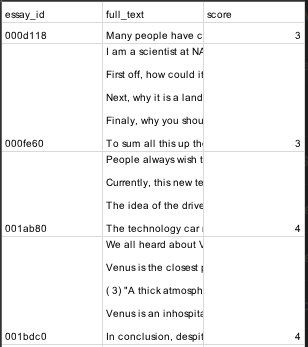

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Library imports and Data Loader
This code block holds our data loader, which reads the dataset, assigns X to the column named "full_text", and y to the column "score" that is also shifted by -1 as deBERTa requires labels to begin with 0.

Maps scores:

[1,2,3,4,5]

to

[0,1,2,3,4]

It then splits the data into train test splits.

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score
from torch.utils.data import Dataset
import os

#Disables annoying message
os.environ["WANDB_DISABLED"] = "true"

#Data loader
def load():
  filename = '/content/drive/My Drive/cs345 goog/train.csv'
  data = pd.read_csv(filename)
  X = data["full_text"].values
  y = data["score"].astype(int).values - 1
  return X, y

X, y = load()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Initialization
This is the model classification and tokenizer initialization for the deBERTa model. We used deberta-v3-base as deberta-v3-large is too memory heavy for colab and the previous deBERTas, deberta and deberta-v2, preform worse than the v3 on classification tasks.

In [ ]:
# Model Classification and Tokenizer for essays
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=6)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dataset Class Explaination
DeBERTa is a Hugging Face model, as such, it requires a specific format before training, in the above code block, we initialize the essays, labels, tokenizer, and max_length(of the essays). Then, we prepare the trainer for tokenized input, by (1) getting the essay and label of an index, (2) tokenizing the essay so it fits, (3) reducing the dimension of tokenized essay for quicker training, and (4) adding a label key tensor required by Hugging Face models and PyTorch's Dataset. Finally we have a simple length check function.

In [ ]:
#Dataset Class
class DatasetClass(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

    def __len__(self):
        return len(self.labels)

## Args/Hyperparaments Initialization
These are the arguments/hyperparameters for the DeBERTa model. The block begins by initializing train and test with the class we made previously. Then, we have a bunch of Training arguments that determine many things about the training.

E.G:

-output_dir='./model': Determines where the model is saved after training

-num_train_epochs=3: Number of passes through the dataset

-per_device_train_batch_size=4: Training batch per device(GPU in our case)

-per_device_eval_batch_size=4: Same as before but evalution

-do_eval=True: Runs trainer.evaluate() and prints each epoch

-logging_dir='./logs': Log directory for training loss, accuracy, etc...

-logging_steps=50: Adds to logs every 50 steps

-save_steps=500: Saves model as a checkpoint every 500 steps

-save_total_limit=1: Can only have 1 checkpoint at a time


In [ ]:
#Args/Hyperparameters for Model
train_dataset = DatasetClass(X_train, y_train, tokenizer)
test_dataset = DatasetClass(X_test, y_test, tokenizer)

args = TrainingArguments(
    output_dir='./model',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Train beginning
Trainer.train() begins the model training.

In [ ]:
#Begin training, make sure on GPU, Runtime -> Change Runtime Type -> T4 GPU
trainer.train()

Epoch,Training Loss,Validation Loss,Qwk
1,0.863900,0.870456,0.482585


## Model Loading
These load a downloaded model back into the notebook, so we don't have to train a new model every time.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./model")
tokenizer = AutoTokenizer.from_pretrained("./model")

## ID Testing Function
A little function for testing that given an essay id from the dataset, and returns the actual and predicted scores.

In [ ]:
#Plug in any essay id and recieve the score the essay predicted
def predict_score(id, model, tokenizer, file):
  train = pd.read_csv(file)
  row = train[train["essay_id"] == id]
  essay = row.iloc[0]["full_text"]
  score = row.iloc[0]["score"]

  device = next(model.parameters()).device

  inputs = tokenizer(essay, truncation=True, padding="max_length", max_length=512, return_tensors="pt").to(device)

  model.eval()
  with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()
        predicted_score = pred_label + 1

  return score, predicted_score

id = "000d118"
score, pscore = predict_score(id, model, tokenizer, "/content/drive/My Drive/cs345 goog/train.csv")
print("Real Score:", score)
print("Predicted Score:", pscore)

Real Score: 3
Predicted Score: 3


## Unseen Essay Prediction
Given 3 of our own, non dataset essays, our DeBERTa model predicts scores for each.

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

df = pd.read_csv("/content/drive/My Drive/cs345 goog/predictions (2).csv")
essays = df["full_text"].tolist()

display(df)

predictions = []

for essay in essays:
    inputs = tokenizer(essay, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()
        predicted_score = pred_label + 1
        predictions.append(predicted_score)

df["predicted_score"] = predictions

display(df)

,essay_id,full_text
0,1,"On February 21, I had the pleasure of attendin..."
1,2,Prompted to find a visual source for my resear...
2,3,The moral theory I would program into an AI wo...


,essay_id,full_text,predicted_score
0,1,"On February 21, I had the pleasure of attendin...",4
1,2,Prompted to find a visual source for my resear...,4
2,3,The moral theory I would program into an AI wo...,2


## Scatter Plot
The scatter plot below uses two sets of data: predicted scores and actual scores. Then shows this data on the scatter plot with the yellow points being predicted scores and the blue points being actual scores.

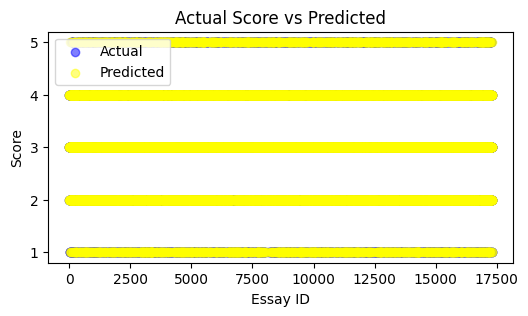

Done


In [ ]:
#Predicts the score to the dataset essays and graphs against Actual scores

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

train = pd.read_csv("/content/drive/My Drive/cs345 goog/train.csv")
train_essays = train["full_text"].tolist()
train["score"] = train["score"].replace(6, 5)

predictions = []
actual_score = []

for i, essay in enumerate(train_essays):
    inputs = tokenizer(essay, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    actual_score.append(train.iloc[i]["score"])

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()
        predicted_score = pred_label + 1
        predictions.append(predicted_score)

import matplotlib.pyplot as plt

#Graph
def graph():
  fig = plt.figure(figsize=(6, 3))
  plt.scatter(range(len(actual_score)), actual_score, color='blue', alpha=0.5, label='Actual')
  plt.scatter(range(len(predictions)), predictions, color='yellow', alpha=0.5, label='Predicted')
  plt.xlabel('Essay ID')
  plt.ylabel('Score')
  plt.title('Actual Score vs Predicted')
  plt.legend()
  plt.show()

graph()

print("Done")

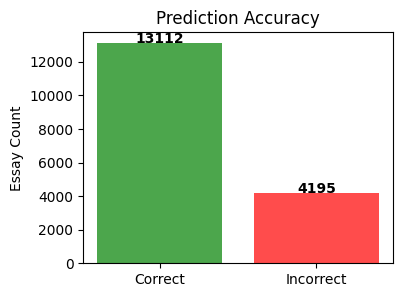

In [ ]:
#Graphs the correct vs incorrect predictions
def graph_accuracy():
    correct = sum(p == a for p, a in zip(predictions, actual_score))
    incorrect = len(predictions) - correct

    labels = ['Correct', 'Incorrect']
    values = [correct, incorrect]
    colors = ['green', 'red']

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.bar(labels, values, color=colors, alpha=0.7)
    ax.set_ylabel("Essay Count")
    ax.set_title("Prediction Accuracy")
    for i, v in enumerate(values):
        ax.text(i, v + 2, str(v), ha='center', fontweight='bold')
    plt.show()

graph_accuracy()

In [ ]:
#Linear SVM vs deBERTa vs Random Forests comparision with accuracy, mean absolute error, and cohen kappa score
from sklearn.metrics import accuracy_score, mean_absolute_error, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


rounded_actual = [int(x) for x in actual_score]
rounded_pred = [int(x) for x in predictions]

acc = accuracy_score(rounded_actual, rounded_pred)
mae = mean_absolute_error(rounded_actual, rounded_pred)
qwk = cohen_kappa_score(rounded_actual, rounded_pred, weights='quadratic')

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ("svm", LinearSVC())
])

svm_pipeline.fit(X_train, y_train)
svm_predict = svm_pipeline.predict(X_test)

svm_acc = accuracy_score(y_test, svm_predict)
svm_mae = mean_absolute_error(y_test, svm_predict)
svm_qwk = cohen_kappa_score(y_test, svm_predict, weights="quadratic")

rf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_qwk = cohen_kappa_score(y_test, rf_pred, weights="quadratic")

print("\n--- Comparison ---")
print(f"DeBERTa | Accuracy: {acc:.4f} | MAE: {mae:.4f} | QWK: {qwk:.4f}")
print(f"SVM | Accuracy: {svm_acc:.4f} | MAE: {svm_mae:.4f} | QWK: {svm_qwk:.4f}")
print(f"RandomForest | Accuracy: {rf_acc:.4f} | MAE: {rf_mae:.4f} | QWK: {rf_qwk:.4f}")



--- Comparison ---
DeBERTa | Accuracy: 0.7576 | MAE: 0.2505 | QWK: 0.8629
SVM | Accuracy: 0.4697 | MAE: 0.6158 | QWK: 0.5854
RandomForest | Accuracy: 0.5176 | MAE: 0.5335 | QWK: 0.5851


## Results Discussion:
The results clearly demonstrate that the DeBERTa model significantly outperforms both the SVM and RandomForest models in essay grading. DeBERTa achieved an accuracy of approximately 75.8%, whereas the SVM and RandomForest models reached only 47% and 51.8% accuracy, respectively. This makes the DeBERTa model over 20 percentage points more accurate than either traditional model. DeBERTa was tested using 17,307 essays and came out with only 4,195 incorrect scores, usually only having the predicted score one point off of the actual score.

### What we learned:
During this project we learned about tokenization, neural network training and pytorch. Tokenization is a fundamental process of NLPs that breaks down text into small units called tokens. The model uses the tokens to represent specific words or phrases. Before deciding to use DeBERTa we looked into some other models, including RoBERTa and BERT. We had never worked with a model like DeBERTa before so it took some research to figure out the best approach. Lastly we learned about pytorch's extensive library when it comes to working with NLPs.

##Contributions:
###Anna
*   Automatic Essay Grader
*   Data Explaination
*   Library imports and Data Loader
*   Scatter Plot
*   Accuracy Score vs Predicted Score graph
*   Results Discussion
*   What we Learned
*   Contributions
*   Data Loader
*   Essay score predictor

###Quinn
*   Library imports and Data Loader
*   Model Initialization
*   Dataset Class
*   Args/Hyperparaments Initialization
*   Train beginning
*   ID Testing Function
*   Unseen Essay Prediction
*   DeBERTa vs Linear SVM vs RF Comparison
*   Correct Incorrect Graph
*   Corresponding Explainations



DeBERTaV3 Documentation: https://huggingface.co/microsoft/deberta-v3-base